In [39]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from lesson_functions import *
import glob
from scipy.ndimage.measurements import label
%matplotlib inline

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]



In [40]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



In [41]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,cells_per_step = 2,hog_gray = False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)+ 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    if hog_gray == True:
        ctrans_tosearch_rgb = cv2.cvtColor(ctrans_tosearch,cv2.COLOR_YCrCb2RGB)
        ctrans_tosearch_gray = cv2.cvtColor(ctrans_tosearch,cv2.COLOR_RGB2GRAY)
        hog = get_hog_features(ctrans_tosearch_gray, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    else:
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            if hog_gray == True:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            else:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
            
            if test_prediction == 1:                
                hot_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    heatmap = add_heat(heatmap,hot_windows)
    return hot_windows,heatmap,windows

In [42]:
def visualize(fig,rows,cols,images,titles):
    for i,img in enumerate(images):
        plt.subplot(rows,cols,i+1)
        plt.title(titles[i])
        img_dims = len(img.shape)
        if img_dims<3:
            plt.imshow(img,cmap='hot')
            plt.title(titles[i])
            plt.axis('off') 
        else:
            plt.imshow(img)
            plt.title(titles[i])
            plt.axis('off')

In [43]:
img_names = glob.glob('./test_images/test*.jpg')
img_names

['./test_images\\test1.jpg',
 './test_images\\test2.jpg',
 './test_images\\test3.jpg',
 './test_images\\test4.jpg',
 './test_images\\test5.jpg',
 './test_images\\test6.jpg',
 './test_images\\test7.jpg']

In [44]:
ystart = 400
ystop = 656
scale = 1.5
img_names = glob.glob('./test_images/*.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
#print('pix_per_cell:',pix_per_cell)
#print('cell_per_block:',cell_per_block)
#print(img.shape)

out_images = []
titles = []

for img_name in img_names:
    
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    hot_windows,heatmap,windows = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_gray = True)
    
    for window in hot_windows:
        cv2.rectangle(img,window[0],window[1],(0,0,255),6)
    
    out_images.append(img)
    titles.append(img_name.split('\\')[1])    
        
    out_images.append(heatmap)
    titles.append(img_name.split('\\')[1]+' heatmap')
    
    heatmap = apply_threshold(heatmap,2)
    labels = label(heatmap)
    
    img_labeled = draw_labeled_bboxes(mpimg.imread(img_name),labels)
    out_images.append(img_labeled)
    titles.append(img_name.split('\\')[1])  
    
    
'''
fig,ax = plt.subplots(1,figsize=(15, 10))
fig.tight_layout()
ax.imshow(img)
plt.show()
'''    

C:\ProgramData\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


'\nfig,ax = plt.subplots(1,figsize=(15, 10))\nfig.tight_layout()\nax.imshow(img)\nplt.show()\n'

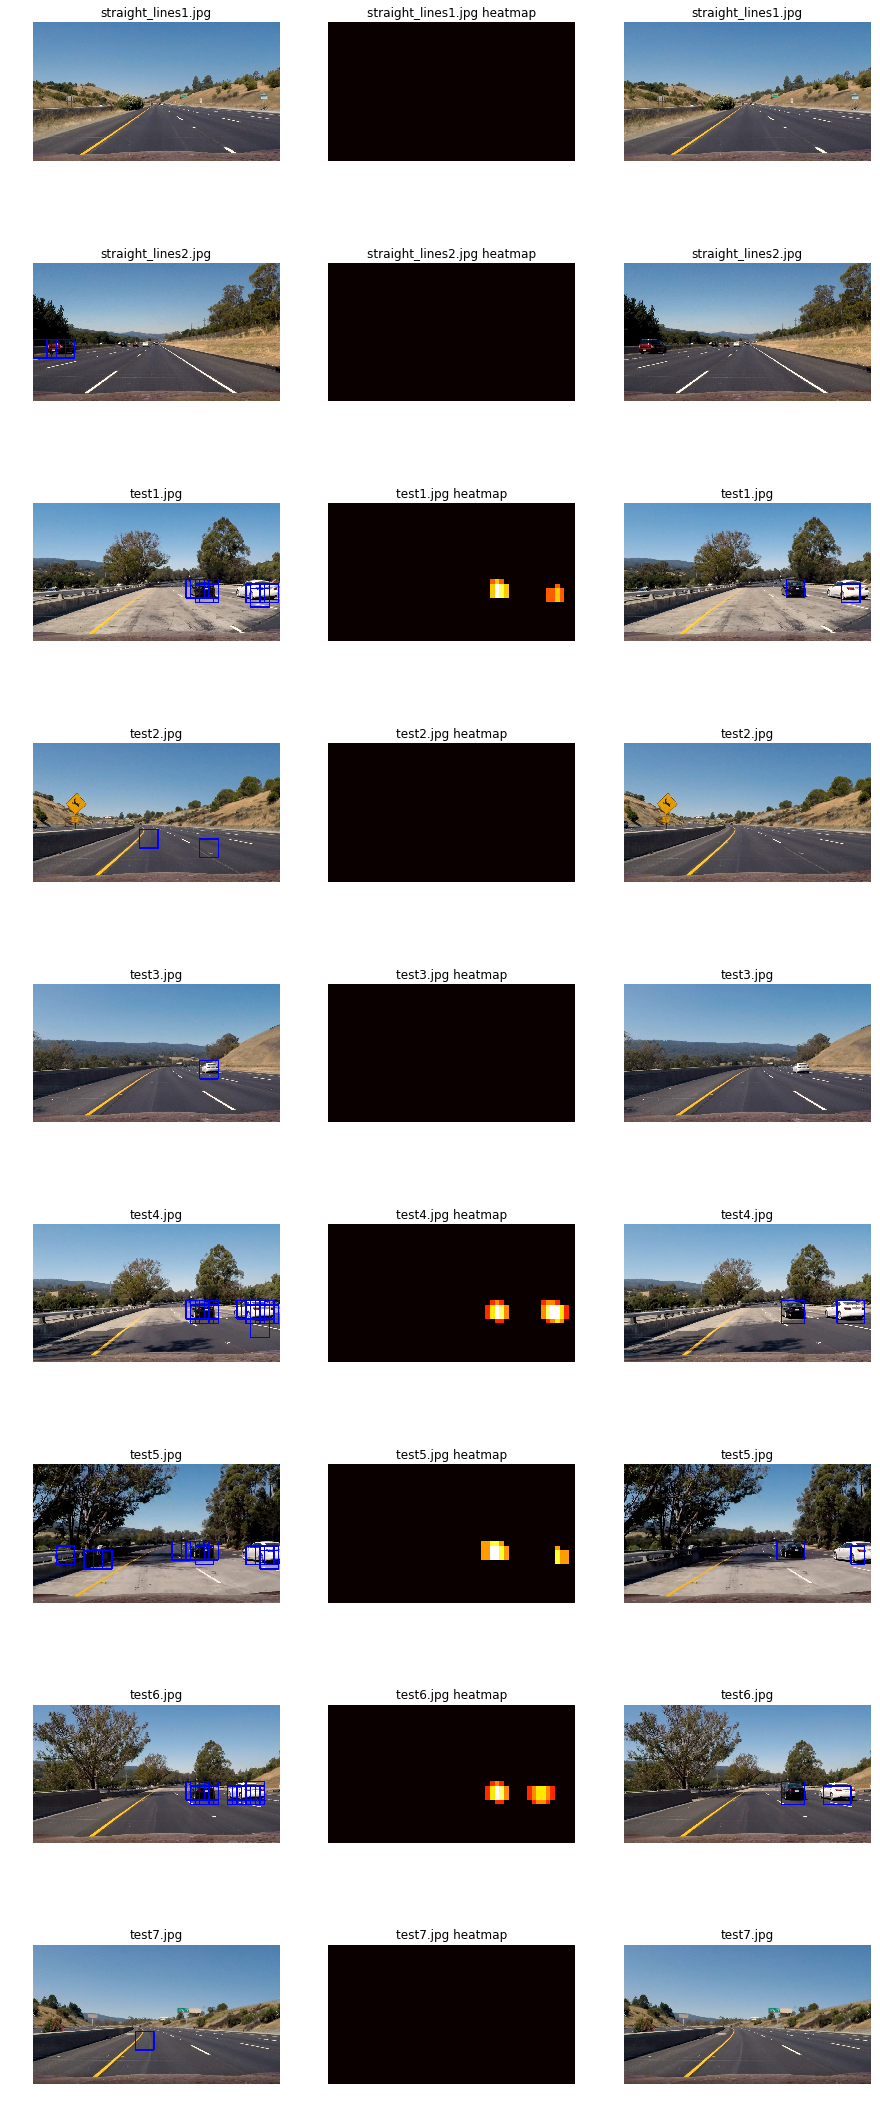

In [45]:
fig = plt.figure(figsize=(15,70))

visualize(fig,16,3,out_images,titles)

In [38]:
def process_image(image):
    
    ystart = 400
    ystop = 720
    scale = 1.5
    
    #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    hot_windows,heatmap = find_cars(image, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap = apply_threshold(heatmap,2)
    labels = label(heatmap)
    output_image = draw_labeled_bboxes(np.copy(image),labels)
    
    return output_image

In [75]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_output_1.mp4'
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('test_video.mp4')

write_clip = clip1.fl_image(process_image)

%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_output_1.mp4
[MoviePy] Writing video project_video_output_1.mp4


100%|█████████▉| 1260/1261 [15:50<00:00,  1.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_1.mp4 

Wall time: 15min 51s
